# Neural Networks with PyTorch - Worked Example

<hr style="border:2px solid gray">

# Set up python imports & bootstrap

In [3]:
import sklearn, sklearn.datasets
import numpy as np

# Matplotlib, but with nicer defaults for Jupyter notebooks in 2021
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 200 


In [4]:
import torch
import torch.nn as nn

torch.manual_seed(31337) # for reproducible runs, manually set the PRNG seed

In [5]:
# Do we have GPU acceleration?
torch.cuda.is_available()

False

<hr style="border:2px solid gray">

# Generate toy datasets

In [6]:
n_samples=200
np.random.seed(0) # reproducible runs for debugging

In [9]:
# our 'easy', linearly separable classification
X,Y=sklearn.datasets.make_classification(n_features=2, n_redundant=0, n_samples=n_samples,
    n_informative=2, random_state=None, n_clusters_per_class=1)

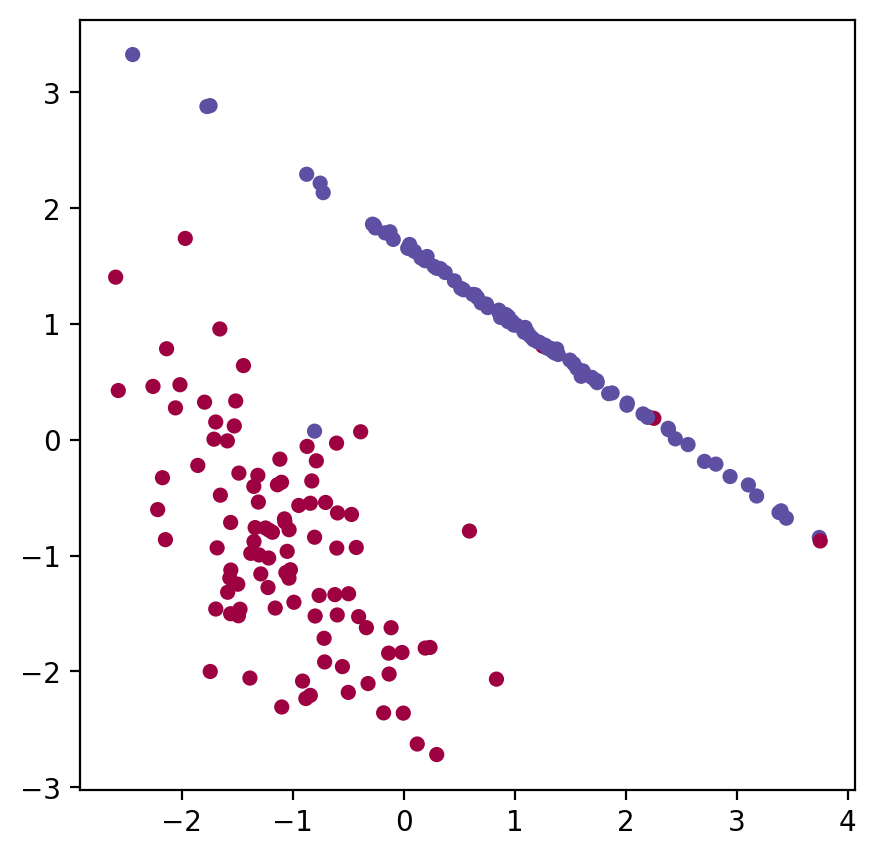

In [10]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

<hr style="border:2px solid gray">

# Pytorch

> Welcome to the (wonderful) world of PyTorch! 
> 
> There are a lot of sharp edges, but PyTorch is still the least worst NN package.
> 
> Documentation: https://pytorch.org/docs/stable/nn.html

In [11]:
# Building a (linear) layer is supper simple! 
# Let's start by building the first half of the single neuron

# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

m=2 # the number of input legs
n=1 # the number of output legs

linearlayer = nn.Linear(m,n)

#nn.linear will generate random weights and biases (here specified by our random seed)

In [12]:
linearlayer(torch.Tensor([1,1]))

tensor([0.2600], grad_fn=<AddBackward0>)

In [13]:
rt=torch.randn(20, m) 
# get a load of random data of the correct size...

In [14]:
linearlayer(rt) # and pass through the linear layer

tensor([[-0.4197],
        [ 0.2589],
        [ 0.0741],
        [-0.3343],
        [ 0.2384],
        [ 0.1441],
        [-0.1722],
        [-0.8525],
        [-0.5155],
        [-0.9872],
        [-0.6629],
        [-0.2337],
        [ 0.2115],
        [ 0.6745],
        [-0.3154],
        [-0.1377],
        [ 0.1775],
        [-0.0575],
        [-0.6354],
        [ 0.0732]], grad_fn=<AddmmBackward0>)

In [15]:
# We can look at the weights and the biases of our model
#  The model is an object-orientated object, so has both data and functions
print("W", linearlayer.weight)
print("b", linearlayer.bias)

W Parameter containing:
tensor([[ 0.4160, -0.0271]], requires_grad=True)
b Parameter containing:
tensor([-0.1289], requires_grad=True)


<hr style="border:2px solid gray">

# OK! Let's rebuild our binary classifier from the first session

> Now we have the full power of Pytorch to train it efficiently
>
> Changing the architecture of the network can be as simple as choosing a different named function

In [16]:
input_size=2 # two dimensional input
output_size=1 # one output

# PyTorch convenience class to define a sequential set of layers. 
# Here we have used a linear layer followed by a sigmoid layer. 
# Outputs from one activation function becomes the input for the next, chained together by forward() functions

model = nn.Sequential(nn.Linear(input_size,output_size), nn.Sigmoid())

print(model) 

# There is an alternative way to build arbitrary models in 
# PyTorch by constructing a Python class
# But this is considerably more complicated, involves a lot of 
# object-orientated boilerplate code, and isn't necessary for 
# simple architectures such as these.

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


In [17]:
# this should work! Just two arb. data points, should generate a scalar output
model(torch.tensor([0.0,0.0])) 

tensor([0.5906], grad_fn=<SigmoidBackward0>)

In [18]:
# See https://pytorch.org/docs/stable/nn.html#loss-functions to find an applicable loss function

lossfunction = nn.L1Loss()

# How does this compare to the self-coded loss function from the previous notebook? 

In [19]:
# This is always a good starting point, for almost any problem!
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate
# But please do experiment with alternatives

In [20]:
# Messing around to convert numpy arrays into PyTorch 'Tensors' and 'datasets' for use in the dataloader
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

# The dataloader works with batches
# it's quite a sophisticated piece of software - it will also shuffle
# around data so that it is fed efficiently to the GPU
# As you are using batches => stochastic gradient descent

trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

In [21]:
# training loop

losses=[]

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for Xtorch,Ytorch in trainloader: # pull a batch from the loader
            y=model(Xtorch) # forward pass through model
            loss=lossfunction(y, Ytorch) # supervised learning
            totalloss+=loss.detach()
            
            loss.backward() # calculate backward (gradient) pass
            optimizer.step() # use gradient info in optimise step
        losses.append(totalloss)

In [22]:
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

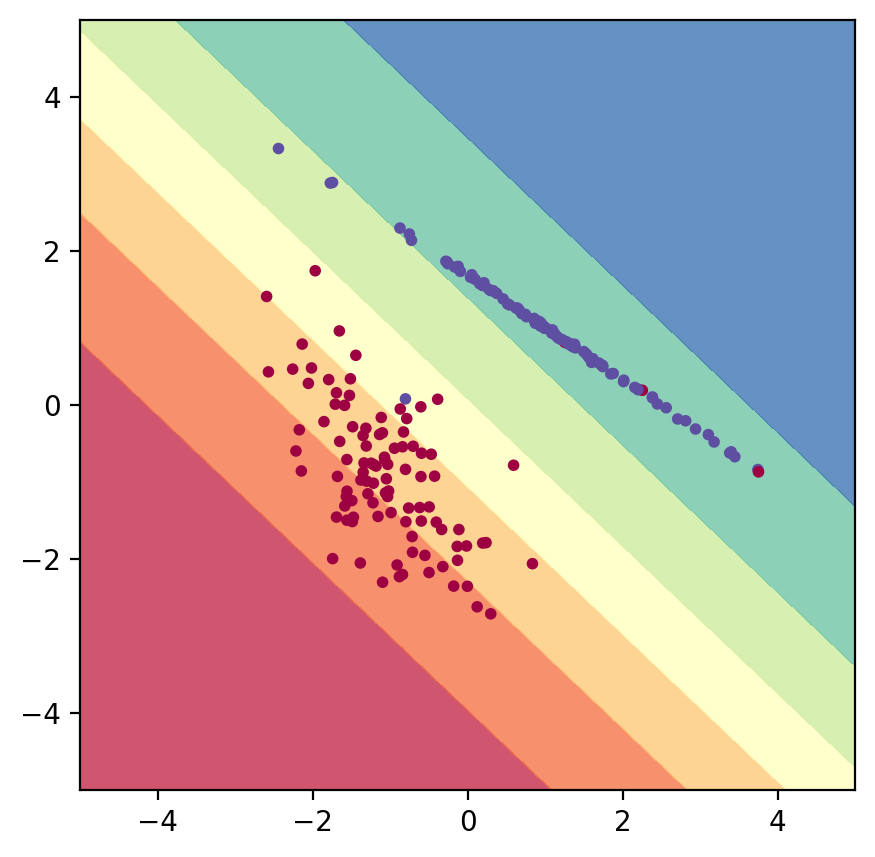

In [23]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

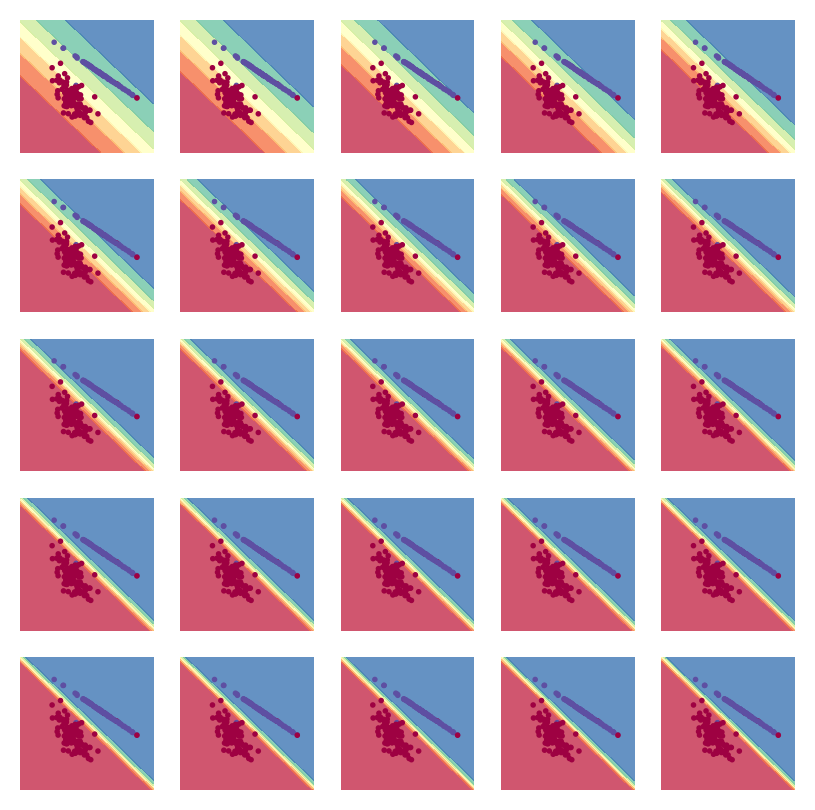

In [24]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)


(0.0, 1.124428940936923)

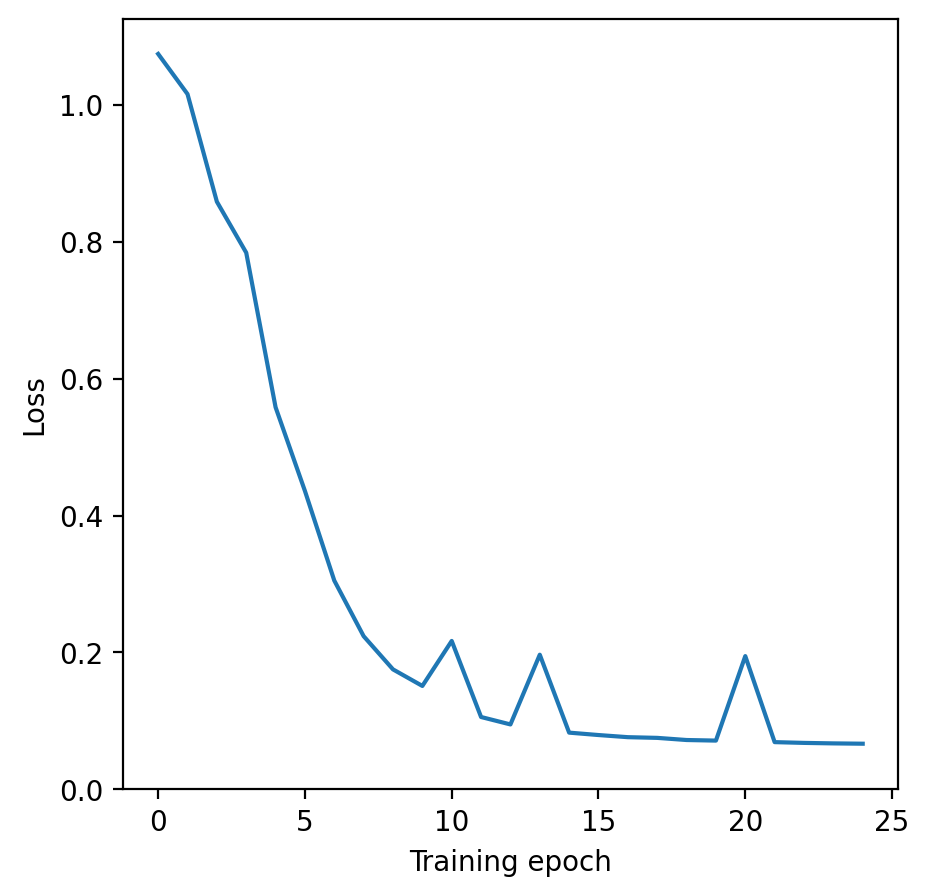

In [25]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

In [26]:
# Accuracy - what fraction of the train data go we correctly predict?
#... write some code here ...

#FS-not required for rest of code


# Actually a ML model like this can be considered probabilistic, 
# but I suggest applying a cutoff probability of 0.5 to compare to 
# the binary data.

In [27]:
# describe all parameters of model
for name,param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[6.6481, 6.7618]], requires_grad=True)
0.bias Parameter containing:
tensor([-0.9631], requires_grad=True)


<hr style="border:2px solid gray">

# Experiment with manually setting weights

0.weight Parameter containing:
tensor([[0., 1.]], requires_grad=True)
0.bias Parameter containing:
tensor([0.], requires_grad=True)
Accuracy tensor(0.8650)


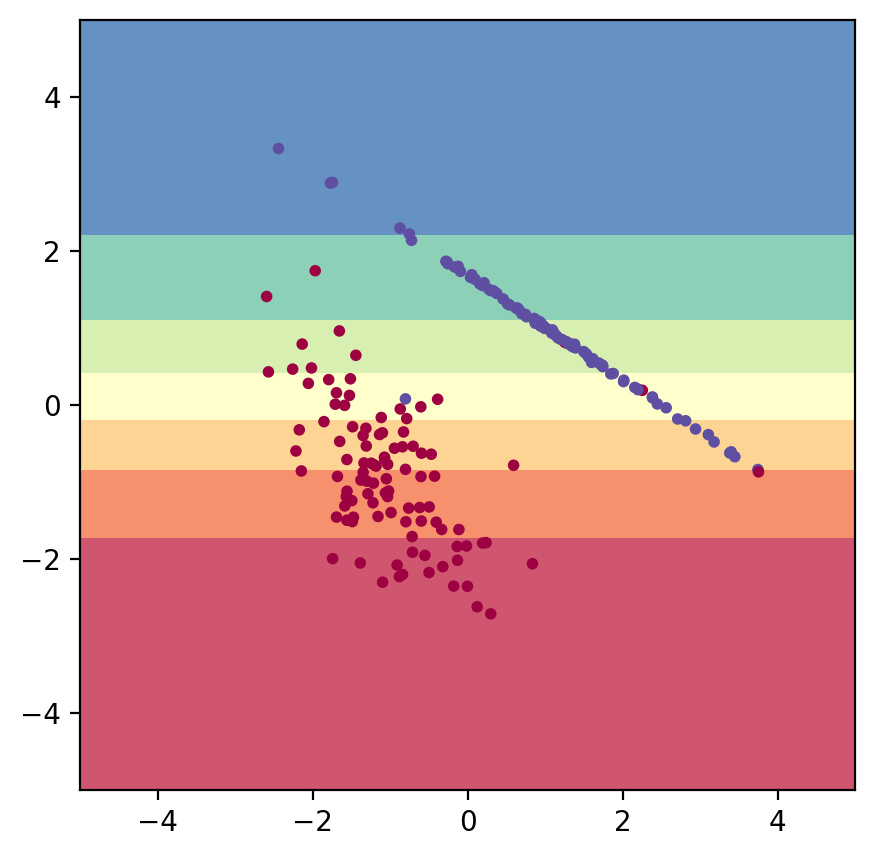

In [28]:
# And we can set the weights for the linear model manually
#  Try and do this to correctly describe the data!
with torch.no_grad():
    model[0].weight[0,0]=0
    model[0].weight[0,1]=1
    model[0].bias[0]=0
    
for name,param in model.named_parameters():
    print(name, param)
    
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

# Accuracy - what fraction of the train data go we correctly predict?
print("Accuracy",(Ytorch == torch.round(model(Xtorch))).float().mean())

<hr style="border:2px solid gray">

# Multilayer perceptron

From the first classwork (and if not, from the experiment above!), we can see that a single neuron is only capable of linearly separating the input data. 

Instead we can make a multi-layer perceptron, which goes beyond the capabilities of a single neuron. It also allows us to begin learning a representation of the data which reduces the dimensionality.

This is where the term 'deep' learning comes from, once you have a deep network of many artificial neuron layers.

In [29]:
X,Y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05) # interleaved semi-circles
X=X*2
Y=Y*2 # scale so it more nicely fits in our 5x5 window

In [30]:
X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

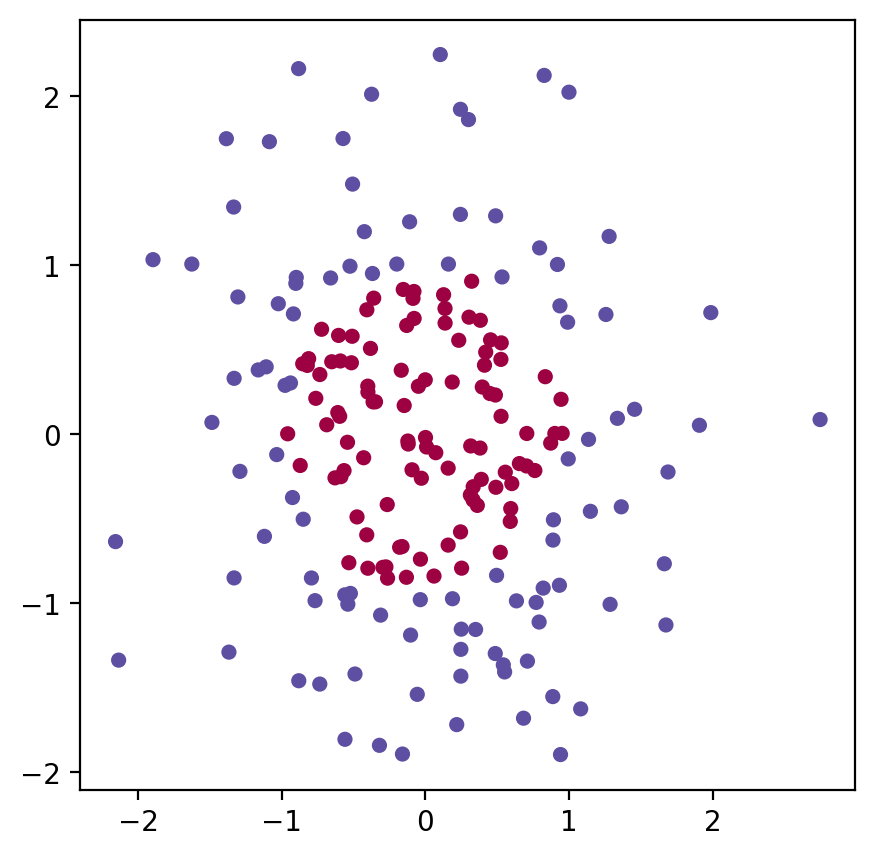

In [31]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

In [32]:
input_size=2 # two dimensional input
hidden_layer=30 # go wild!
output_size=1 # one output

# PyTorch convenience class to define a sequential set of layers

model = nn.Sequential( nn.Linear(input_size, hidden_layer), nn.ReLU(), nn.Linear(30,1), nn.Sigmoid())

print(model)


Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
  (3): Sigmoid()
)


In [33]:
# this should work! Just two arb. data points, should generate a scalar output
model(torch.tensor([0.0,0.0])) 

tensor([0.5010], grad_fn=<SigmoidBackward0>)

In [34]:
# See https://pytorch.org/docs/stable/nn.html#loss-functions

lossfunction = nn.L1Loss()

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate

In [36]:
# Messing around to convert numpy arrays into PyTorch 'Tensors', and 'datasets' for use in the dataloader
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

# The dataloader works with batches
# it's quite a sophisticated piece of software - it will also shuffle
# around data so that it is fed efficiently to the GPU
# As you are using batches => stochastic gradient descent
trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

In [37]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #lr = learning rate

In [38]:
# Messing around to convert numpy arrays into PyTorch 'Tensors', and 'datasets' for use in the dataloader
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

# The dataloader works with batches
# it's quite a sophisticated piece of software - it will also shuffle
# around data so that it is fed efficiently to the GPU
# As you are using batches => stochastic gradient descent
trainloader = torch.utils.data.DataLoader( D , batch_size=16, shuffle=True)

In [39]:
# training loop

losses=[]

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for Xtorch,Ytorch in trainloader: # pull a batch from the loader
            y=model(Xtorch) # forward pass through model
            loss=lossfunction(y, Ytorch) # supervised learning
            totalloss+=loss.detach()
            
            loss.backward() # calculate backward (gradient) pass
            optimizer.step() # use gradient info in optimise step
        losses.append(totalloss)

In [40]:
# make a grid of predictions, for plotting the decision boundary
N=400
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

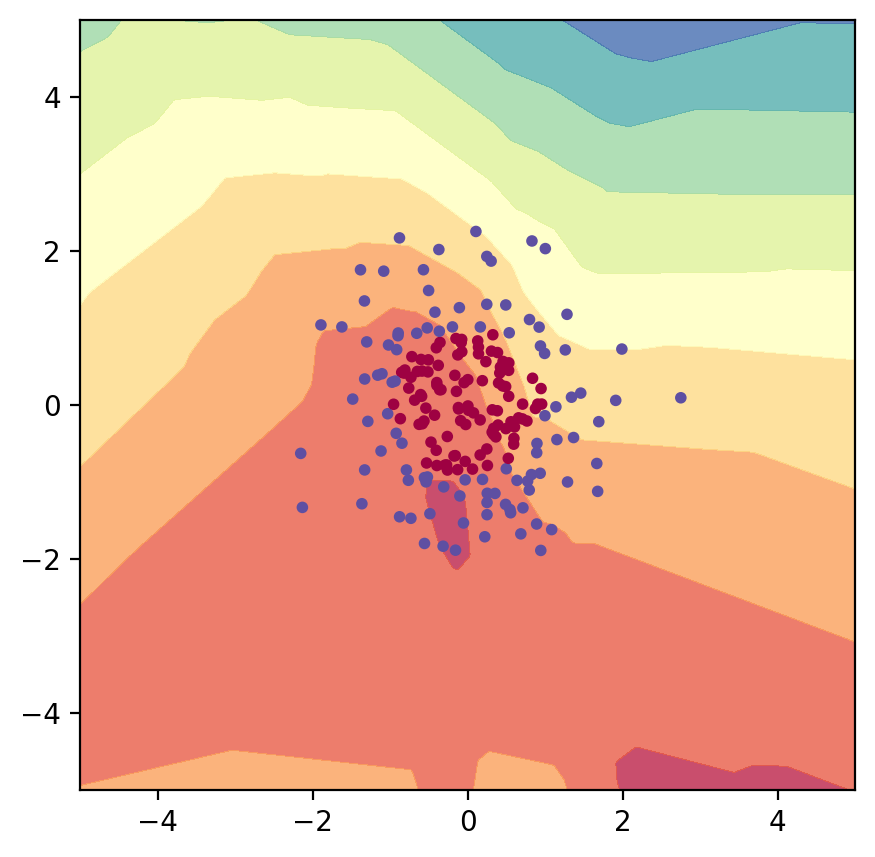

In [41]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

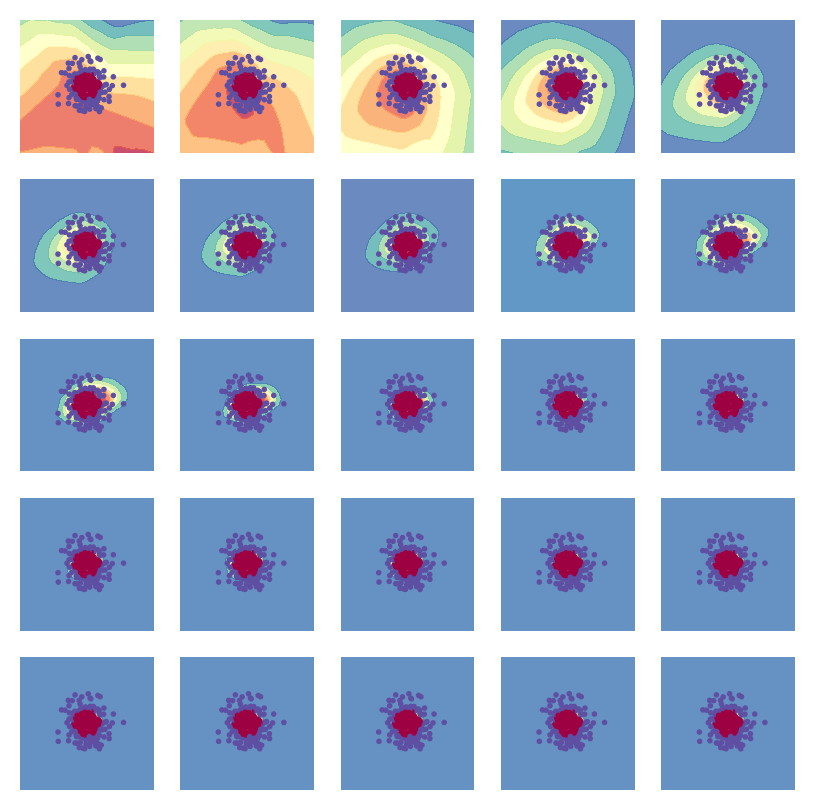

In [42]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)


(0.0, 6.705628636479378)

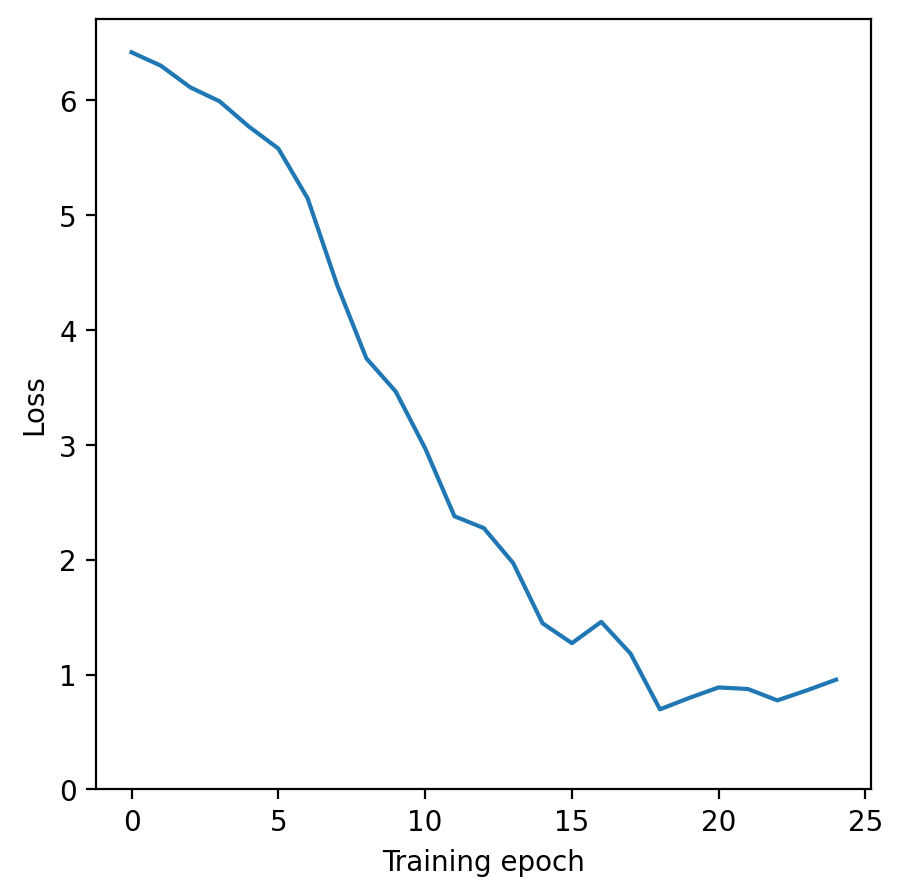

In [43]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

In [44]:
# Accuracy
...
#Not required for code to run

# Actually a ML model like this can be considered probabilistic, 
# but we are applying a cutoff probability of 0.5 to compare to 
# the binary data.

In [45]:
# let's have a look at all our model parameters (including weights)
#  Note how much more complex we are than two weights!
model(Xtorch)

tensor([[5.4866e-08],
        [4.1441e-01],
        [6.9216e-13],
        [8.6809e-01],
        [3.8809e-06],
        [9.9988e-01],
        [8.3288e-06],
        [2.0878e-07],
        [7.9983e-01],
        [1.0000e+00],
        [2.1600e-03],
        [2.9351e-05],
        [3.2806e-04],
        [3.6418e-01],
        [3.7145e-04],
        [9.8420e-01],
        [9.9880e-01],
        [7.5253e-06],
        [1.0000e+00],
        [1.0000e+00],
        [5.2908e-14],
        [9.2304e-07],
        [1.0000e+00],
        [8.2857e-01],
        [7.2724e-14],
        [1.1115e-08],
        [8.4712e-01],
        [7.2901e-14],
        [1.9383e-07],
        [2.5644e-07],
        [1.0000e+00],
        [9.9882e-01],
        [9.9995e-01],
        [1.1718e-06],
        [1.0000e+00],
        [1.0000e+00],
        [1.6397e-10],
        [1.0000e+00],
        [1.0958e-13],
        [1.0000e+00],
        [5.2405e-01],
        [1.0000e+00],
        [9.9999e-01],
        [6.8523e-05],
        [1.0000e+00],
        [1